In [259]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

# Read And Clean Data

In [260]:
leads_data = pd.read_csv('Leads.csv')
leads_data.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,...,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,...,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,...,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [261]:
leads_data.shape

(9240, 37)

In [262]:
# Converting 'Select' values to NaN.
leads_data = leads_data.replace('Select', np.nan)

In [263]:
leads_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
Prospect ID                                      9240 non-null object
Lead Number                                      9240 non-null int64
Lead Origin                                      9240 non-null object
Lead Source                                      9204 non-null object
Do Not Email                                     9240 non-null object
Do Not Call                                      9240 non-null object
Converted                                        9240 non-null int64
TotalVisits                                      9103 non-null float64
Total Time Spent on Website                      9240 non-null int64
Page Views Per Visit                             9103 non-null float64
Last Activity                                    9137 non-null object
Country                                          6779 non-null object
Specialization                                   5860 

In [264]:
# Checking the percentage of missing values
round(100*(leads_data.isnull().sum()/len(leads_data.index)), 2)

Prospect ID                                       0.00
Lead Number                                       0.00
Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                   36.58
How did you hear about X Education               78.46
What is your current occupation                  29.11
What matters most to you in choosing a course    29.32
Search                                            0.00
Magazine                                          0.00
Newspaper 

### Missing values

In [265]:
# Ignore columns with more than 70% of the rows have null values
leads_data = leads_data.loc[:, leads_data.isnull().sum()/len(leads_data.index) <= .7]
leads_data.shape

(9240, 35)

In [266]:
leads_data['Country'].describe()

count      6779
unique       38
top       India
freq       6492
Name: Country, dtype: object

In [267]:
# Since most of the country value is India, we can set the null value as 'India'
leads_data['Country'] = leads_data['Country'].replace(np.nan, 'India')

In [268]:
# The lead may not have found their option on the list or may not have any specialization.
# So we'll categorize them as 'Others'
leads_data['Specialization'] = leads_data['Specialization'].replace(np.nan, 'Others')

In [269]:
# Since Lead Quality is based on intution,
# We can assume that they did not select anything because were not 'Not Sure'
leads_data['Lead Quality'] = leads_data['Lead Quality'].replace(np.nan, 'Not Sure')

In [270]:
# 45% is missing values. We can just remove them.
leads_data = leads_data.drop(['Asymmetrique Activity Index', 'Asymmetrique Activity Score',
                              'Asymmetrique Profile Index','Asymmetrique Profile Score'], axis=1)

In [271]:
leads_data['City'].describe()

count       5571
unique         6
top       Mumbai
freq        3222
Name: City, dtype: object

In [272]:
# More than 50% of City is Mumbai. We can set null values as 'Mumbai'.
leads_data['City'] = leads_data['City'].replace(np.nan, 'Mumbai')

In [273]:
leads_data['Tags'].describe()

count                                    5887
unique                                     26
top       Will revert after reading the email
freq                                     2072
Name: Tags, dtype: object

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 <a list of 26 Text xticklabel objects>)

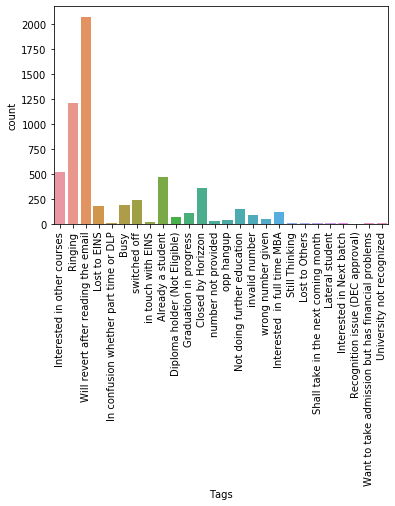

In [274]:
sns.countplot(leads_data['Tags'])
plt.xticks(rotation=90)

In [275]:
# Since most of the Tags value is 'Will revert after reading the email', we can set the null value as that.
leads_data['Tags'] = leads_data['Tags'].replace(np.nan, 'Will revert after reading the email')

In [276]:
leads_data['What matters most to you in choosing a course'].describe()

count                        6531
unique                          3
top       Better Career Prospects
freq                         6528
Name: What matters most to you in choosing a course, dtype: object

In [277]:
col = 'What matters most to you in choosing a course'
leads_data[col] = leads_data[col].replace(np.nan, 'Better Career Prospects')

In [278]:
leads_data['What is your current occupation'].describe()

count           6550
unique             6
top       Unemployed
freq            5600
Name: What is your current occupation, dtype: object

In [279]:
col = 'What is your current occupation'
leads_data[col] = leads_data[col].replace(np.nan, 'Unemployed')

In [280]:
round(100*(leads_data.isnull().sum()/len(leads_data.index)), 2)

Prospect ID                                      0.00
Lead Number                                      0.00
Lead Origin                                      0.00
Lead Source                                      0.39
Do Not Email                                     0.00
Do Not Call                                      0.00
Converted                                        0.00
TotalVisits                                      1.48
Total Time Spent on Website                      0.00
Page Views Per Visit                             1.48
Last Activity                                    1.11
Country                                          0.00
Specialization                                   0.00
What is your current occupation                  0.00
What matters most to you in choosing a course    0.00
Search                                           0.00
Magazine                                         0.00
Newspaper Article                                0.00
X Education Forums          

In [281]:
# Remove the rest of rows with null values
leads_data = leads_data.dropna()

In [282]:
round(100*(leads_data.isnull().sum()/len(leads_data.index)), 2)

Prospect ID                                      0.0
Lead Number                                      0.0
Lead Origin                                      0.0
Lead Source                                      0.0
Do Not Email                                     0.0
Do Not Call                                      0.0
Converted                                        0.0
TotalVisits                                      0.0
Total Time Spent on Website                      0.0
Page Views Per Visit                             0.0
Last Activity                                    0.0
Country                                          0.0
Specialization                                   0.0
What is your current occupation                  0.0
What matters most to you in choosing a course    0.0
Search                                           0.0
Magazine                                         0.0
Newspaper Article                                0.0
X Education Forums                            

No more null values remaining.

In [283]:
# Prospect ID and Lead Number are unique identifiers. They wont add any value to the solution.
leads_data = leads_data.drop(columns=['Prospect ID', 'Lead Number'])

# EDA

In [284]:
# Conversion rate
round((sum(leads_data['Converted'])/len(leads_data['Converted'].index))*100, 2)

37.86

#### Lead Origin

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

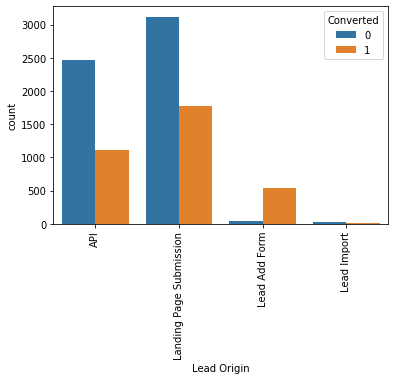

In [285]:
sns.countplot(x='Lead Origin', hue='Converted', data=leads_data)
plt.xticks(rotation=90)

- We have to focus more on conversion of leads of Landing Page Submission and API.
- Lead Add Form conversion is high but the count is low. So we need to get more leads from it.

#### Lead Source

In [286]:
leads_data['Lead Source'].unique()

array(['Olark Chat', 'Organic Search', 'Direct Traffic', 'Google',
       'Referral Sites', 'Reference', 'google', 'Welingak Website',
       'Facebook', 'blog', 'Pay per Click Ads', 'bing', 'Social Media',
       'WeLearn', 'Click2call', 'Live Chat', 'welearnblog_Home',
       'youtubechannel', 'testone', 'Press_Release', 'NC_EDM'],
      dtype=object)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 <a list of 21 Text xticklabel objects>)

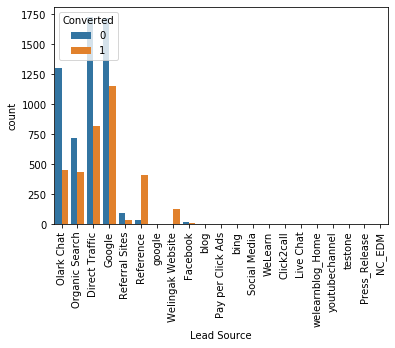

In [287]:
sns.countplot(x='Lead Source', hue='Converted', data=leads_data)
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

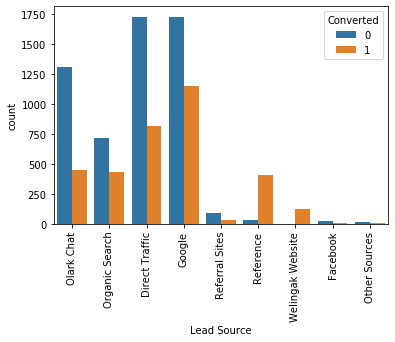

In [288]:
leads_data['Lead Source'] = leads_data['Lead Source'].replace({'google': 'Google'}) 

# We can club the low count categories into one
vals = ['Click2call', 'Live Chat', 'NC_EDM', 'Pay per Click Ads', 'Press_Release',
        'Social Media', 'WeLearn', 'bing', 'blog', 'testone', 'welearnblog_Home', 'youtubechannel']
leads_data['Lead Source'] = leads_data['Lead Source'].replace(vals, 'Other Sources')

sns.countplot(x='Lead Source', hue='Converted', data=leads_data)
plt.xticks(rotation=90)

- We have to focus more on conversion of leads of Olark Chat, Organic Search, Direct Trafic and Google since they produce most number of leads.
- Reference and Welingak Website's conversion rate is high but the count is low. So we need to get more leads through them.

#### Do Not Call

In [289]:
leads_data['Do Not Call'].describe()

count     9074
unique       2
top         No
freq      9072
Name: Do Not Call, dtype: object

- Almost all records are No

#### Do Not Email

In [290]:
leads_data['Do Not Email'].describe()

count     9074
unique       2
top         No
freq      8358
Name: Do Not Email, dtype: object

- Almost all records are No

#### Total Visits

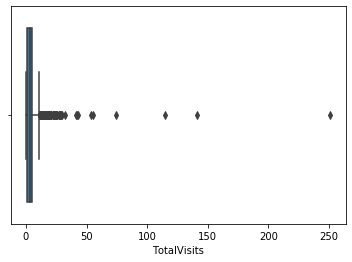

In [291]:
sns.boxplot(leads_data['TotalVisits'])

In [292]:
lower_bound = leads_data['TotalVisits'].quantile([0.05]).values[0]
upper_bound = leads_data['TotalVisits'].quantile([0.95]).values[0]

# Capping the outliers to the 5th and 95th percentile
leads_data['TotalVisits'][leads_data['TotalVisits'] <= lower_bound] = lower_bound
leads_data['TotalVisits'][leads_data['TotalVisits'] >= upper_bound] = upper_bound

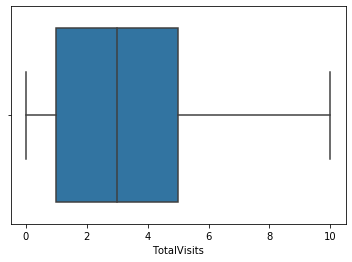

In [293]:
sns.boxplot(leads_data['TotalVisits'])

Outliers have been removed

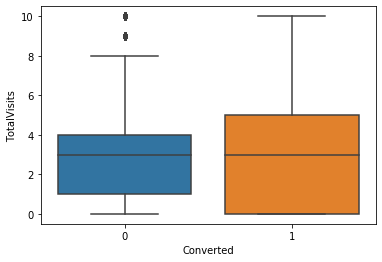

In [294]:
sns.boxplot(y='TotalVisits', x='Converted', data=leads_data)

- Medians are the same. Cant't infer anything.

#### Total Time Spent On Website

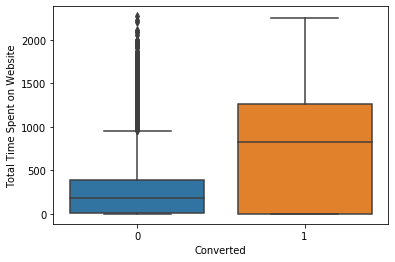

In [295]:
sns.boxplot(y='Total Time Spent on Website', x='Converted', data=leads_data)

- Leads who spend more time on website converts

#### Page Views Per Visit

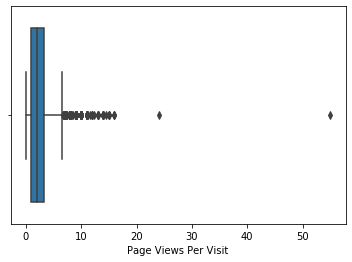

In [296]:
sns.boxplot(leads_data['Page Views Per Visit'])

Some outliers present

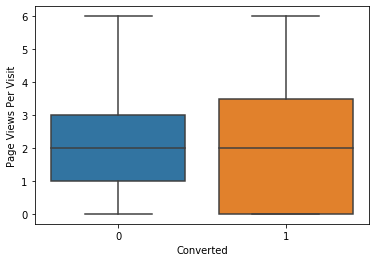

In [297]:
lower_bound = leads_data['Page Views Per Visit'].quantile([0.05]).values[0]
upper_bound = leads_data['Page Views Per Visit'].quantile([0.95]).values[0]

# Capping the outliers to the 5th and 95th percentile
leads_data['Page Views Per Visit'][leads_data['Page Views Per Visit'] <= lower_bound] = lower_bound
leads_data['Page Views Per Visit'][leads_data['Page Views Per Visit'] >= upper_bound] = upper_bound

sns.boxplot(y='Page Views Per Visit', x='Converted', data=leads_data)

- Medians are the same. Cant't infer anything.

#### Last Activity

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text xticklabel objects>)

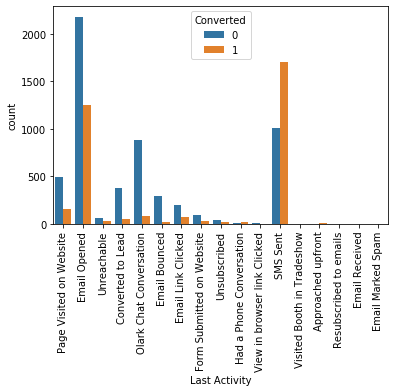

In [298]:
sns.countplot(x='Last Activity', hue='Converted', data=leads_data)
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

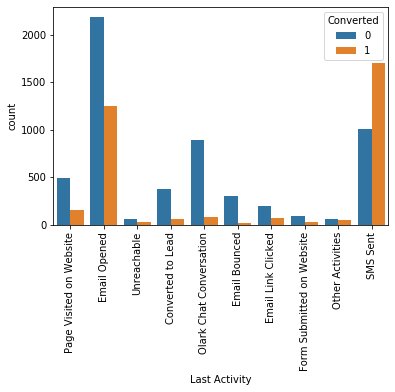

In [299]:
# Club low count activities into "Other Activities"
varlist = ['Unsubscribed', 'Had a Phone Conversation', 'View in browser link Clicked', 'Visited Booth in Tradeshow',
           'Approached upfront','Resubscribed to emails','Email Received', 'Email Marked Spam']
leads_data['Last Activity'] = leads_data['Last Activity'].replace(varlist, 'Other Activities')

sns.countplot(x='Last Activity', hue='Converted', data=leads_data)
plt.xticks(rotation=90)

- Highest conversion happened for leads with SMS Sent as last activity
- Leads with Email opened as last activity are the most.

#### Country

In [300]:
leads_data['Country'].describe()

count      9074
unique       38
top       India
freq       8787
Name: Country, dtype: object

- Almost all records are India

#### Specialization

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 <a list of 19 Text xticklabel objects>)

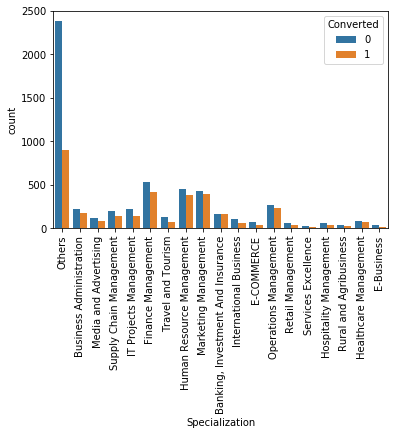

In [301]:
sns.countplot(x='Specialization', hue='Converted', data=leads_data)
plt.xticks(rotation=90)

- Most conversion happens with leads who are specialized in other fields

#### What Is Your Current Occupation

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

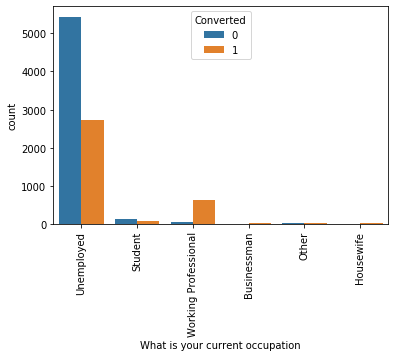

In [302]:
sns.countplot(x='What is your current occupation', hue='Converted', data=leads_data)
plt.xticks(rotation=90)

- Most of the leads are unempolyed with around 40% of them converted.
- Work professionals have way higher conversion rate

#### What Matters Most To You In Choosing a Course

In [303]:
leads_data['What matters most to you in choosing a course'].describe()

count                        9074
unique                          3
top       Better Career Prospects
freq                         9072
Name: What matters most to you in choosing a course, dtype: object

- Most of the data is Better Career Prospects. Can't infer anything.

#### Search

In [304]:
leads_data['Search'].describe()

count     9074
unique       2
top         No
freq      9060
Name: Search, dtype: object

- Most of the data is No. Can't infer anything.

#### Magazine

In [305]:
leads_data['Magazine'].describe()

count     9074
unique       1
top         No
freq      9074
Name: Magazine, dtype: object

- All of the data is No. Can't infer anything.

#### Newspaper Article

In [306]:
leads_data['Newspaper Article'].describe()

count     9074
unique       2
top         No
freq      9072
Name: Newspaper Article, dtype: object

- Most of the data is No. Can't infer anything.

#### X Education Forums

In [307]:
leads_data['X Education Forums'].describe()

count     9074
unique       2
top         No
freq      9073
Name: X Education Forums, dtype: object

- Most of the data is No. Can't infer anything.

#### Newspaper

In [308]:
leads_data['Newspaper'].describe()

count     9074
unique       2
top         No
freq      9073
Name: Newspaper, dtype: object

- Most of the data is No. Can't infer anything.

#### Digital Advertisement, Through Recommendations, Receive More Updates About Our Courses

In [309]:
leads_data['Digital Advertisement'].describe()

count     9074
unique       2
top         No
freq      9070
Name: Digital Advertisement, dtype: object

In [310]:
leads_data['Through Recommendations'].describe()

count     9074
unique       2
top         No
freq      9067
Name: Through Recommendations, dtype: object

In [311]:
leads_data['Receive More Updates About Our Courses'].describe()

count     9074
unique       1
top         No
freq      9074
Name: Receive More Updates About Our Courses, dtype: object

- Not enough variation in data. Cant infer anything.

#### Tags

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 <a list of 26 Text xticklabel objects>)

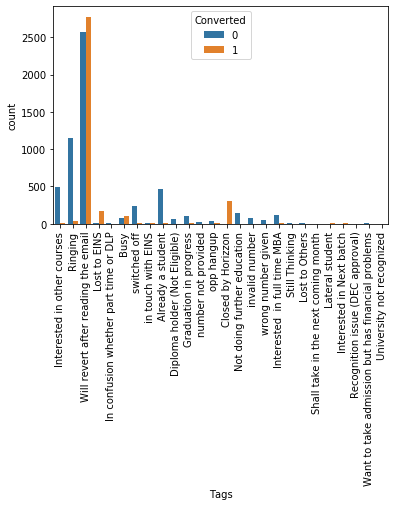

In [312]:
sns.countplot(x='Tags', hue='Converted', data=leads_data)
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text xticklabel objects>)

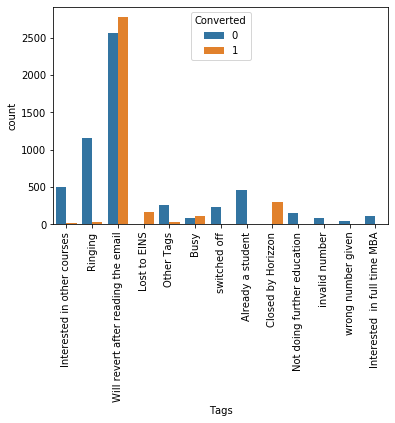

In [313]:
# Club low count tags
varlist = ['In confusion whether part time or DLP', 'in touch with EINS', 'Diploma holder (Not Eligible)',
           'Approached upfront', 'Graduation in progress', 'number not provided',
           'opp hangup', 'Still Thinking', 'Lost to Others', 'Shall take in the next coming month',
           'Lateral student', 'Interested in Next batch', 'Recognition issue (DEC approval)',
           'Want to take admission but has financial problems', 'University not recognized']
leads_data['Tags'] = leads_data['Tags'].replace(varlist, 'Other Tags')

sns.countplot(x='Tags', hue='Converted', data=leads_data)
plt.xticks(rotation=90)

- Most leads who are tagged as 'Will revert after the email' were converted.

#### Lead Quality

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

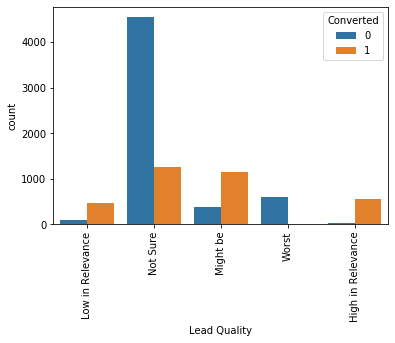

In [314]:
sns.countplot(x='Lead Quality', hue='Converted', data=leads_data)
plt.xticks(rotation=90)

#### Update Me on Supply Chain Content, Get Updates on DM Content, I Agree To Pay The Amount Through Cheque, A free copy of Mastering The Interview

In [315]:
leads_data['Update me on Supply Chain Content'].describe()

count     9074
unique       1
top         No
freq      9074
Name: Update me on Supply Chain Content, dtype: object

In [316]:
leads_data['Get updates on DM Content'].describe()

count     9074
unique       1
top         No
freq      9074
Name: Get updates on DM Content, dtype: object

In [317]:
leads_data['I agree to pay the amount through cheque'].describe()

count     9074
unique       1
top         No
freq      9074
Name: I agree to pay the amount through cheque, dtype: object

In [318]:
leads_data['A free copy of Mastering The Interview'].describe()

count     9074
unique       2
top         No
freq      6186
Name: A free copy of Mastering The Interview, dtype: object

- Not enough variation in these data. Cant infer anything.

#### City

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

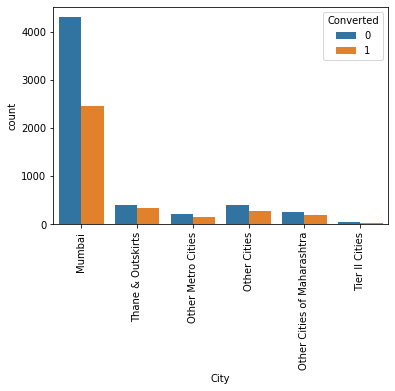

In [319]:
sns.countplot(x='City', hue='Converted', data=leads_data)
plt.xticks(rotation=90)

- Most of the leads are from Mumbai.

#### Last Notable Activity

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

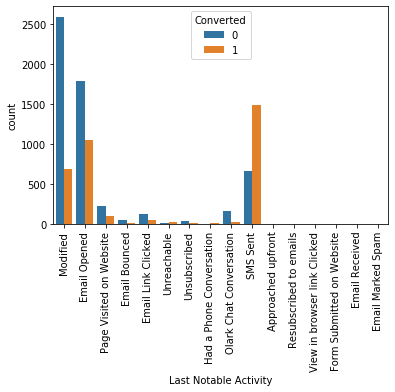

In [320]:
sns.countplot(x='Last Notable Activity', hue='Converted', data=leads_data)
plt.xticks(rotation=90)

- Most conversion happens with leads whos last notable activity is SMS Sent

### EDA Conclusion
We have found that most of these variables dont add any value to model. So we can safely drop these columns.

In [321]:
drop_cols = ['Do Not Call', 'Do Not Email', 'Country', 'What matters most to you in choosing a course',
               'Search', 'Magazine', 'Newspaper Article', 'X Education Forums', 'Newspaper',
               'Digital Advertisement', 'Through Recommendations', 'Receive More Updates About Our Courses',
               'Update me on Supply Chain Content', 'Get updates on DM Content',
               'I agree to pay the amount through cheque', 'A free copy of Mastering The Interview']
leads_data = leads_data.drop(drop_cols, axis=1)

In [322]:
leads_data.shape

(9074, 13)

In [323]:
leads_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9074 entries, 0 to 9239
Data columns (total 13 columns):
Lead Origin                        9074 non-null object
Lead Source                        9074 non-null object
Converted                          9074 non-null int64
TotalVisits                        9074 non-null float64
Total Time Spent on Website        9074 non-null int64
Page Views Per Visit               9074 non-null float64
Last Activity                      9074 non-null object
Specialization                     9074 non-null object
What is your current occupation    9074 non-null object
Tags                               9074 non-null object
Lead Quality                       9074 non-null object
City                               9074 non-null object
Last Notable Activity              9074 non-null object
dtypes: float64(2), int64(2), object(9)
memory usage: 1.3+ MB


### Create dummy variables (One-Hot Encoding) for categorical variables with multiple level

In [324]:
categorical_vars = ['Lead Origin', 'Lead Source', 'Last Activity', 'Specialization',
                    'What is your current occupation', 'Tags', 'Lead Quality', 'City', 'Last Notable Activity']
dummy = pd.get_dummies(leads_data[categorical_vars], drop_first=True)
dummy.head()

,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Source_Facebook,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Other Sources,Lead Source_Reference,Lead Source_Referral Sites,...,Last Notable Activity_Form Submitted on Website,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_Resubscribed to emails,Last Notable Activity_SMS Sent,Last Notable Activity_Unreachable,Last Notable Activity_Unsubscribed,Last Notable Activity_View in browser link Clicked
0,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,1,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [325]:
# Add dummy variables to main data
leads_data = pd.concat([leads_data, dummy], axis=1)
leads_data.head()

,Lead Origin,Lead Source,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Specialization,What is your current occupation,Tags,...,Last Notable Activity_Form Submitted on Website,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_Resubscribed to emails,Last Notable Activity_SMS Sent,Last Notable Activity_Unreachable,Last Notable Activity_Unsubscribed,Last Notable Activity_View in browser link Clicked
0,API,Olark Chat,0,0.0,0,0.0,Page Visited on Website,Others,Unemployed,Interested in other courses,...,0,0,1,0,0,0,0,0,0,0
1,API,Organic Search,0,5.0,674,2.5,Email Opened,Others,Unemployed,Ringing,...,0,0,0,0,0,0,0,0,0,0
2,Landing Page Submission,Direct Traffic,1,2.0,1532,2.0,Email Opened,Business Administration,Student,Will revert after reading the email,...,0,0,0,0,0,0,0,0,0,0
3,Landing Page Submission,Direct Traffic,0,1.0,305,1.0,Unreachable,Media and Advertising,Unemployed,Ringing,...,0,0,1,0,0,0,0,0,0,0
4,Landing Page Submission,Google,1,2.0,1428,1.0,Converted to Lead,Others,Unemployed,Will revert after reading the email,...,0,0,1,0,0,0,0,0,0,0


In [326]:
# Drop original columns
leads_data = leads_data.drop(categorical_vars, axis=1)
leads_data.head()

,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Source_Facebook,Lead Source_Google,Lead Source_Olark Chat,...,Last Notable Activity_Form Submitted on Website,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_Resubscribed to emails,Last Notable Activity_SMS Sent,Last Notable Activity_Unreachable,Last Notable Activity_Unsubscribed,Last Notable Activity_View in browser link Clicked
0,0,0.0,0,0.0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
1,0,5.0,674,2.5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,2.0,1532,2.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1.0,305,1.0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,1,2.0,1428,1.0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0


In [327]:
leads_data.describe()

,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Source_Facebook,Lead Source_Google,Lead Source_Olark Chat,...,Last Notable Activity_Form Submitted on Website,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_Resubscribed to emails,Last Notable Activity_SMS Sent,Last Notable Activity_Unreachable,Last Notable Activity_Unsubscribed,Last Notable Activity_View in browser link Clicked
count,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,...,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000
mean,0.378554,3.191867,482.887481,2.265943,0.538351,0.064029,0.003306,0.003416,0.316619,0.193189,...,0.000110,0.001543,0.360040,0.020168,0.035045,0.000110,0.237161,0.003527,0.004959,0.000110
std,0.485053,2.780618,545.256560,1.790991,0.498554,0.244818,0.057407,0.058353,0.465183,0.394822,...,0.010498,0.039251,0.480038,0.140581,0.183904,0.010498,0.425365,0.059283,0.070251,0.010498
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,11.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3.000000,246.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,5.000000,922.750000,3.200000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,10.000000,2272.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Train-Test Split

In [328]:
# Putting feature variable to X
X = leads_data.drop(['Converted'], axis=1)
X.head()

,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Source_Facebook,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,...,Last Notable Activity_Form Submitted on Website,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_Resubscribed to emails,Last Notable Activity_SMS Sent,Last Notable Activity_Unreachable,Last Notable Activity_Unsubscribed,Last Notable Activity_View in browser link Clicked
0,0.0,0,0.0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
1,5.0,674,2.5,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2.0,1532,2.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,305,1.0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,2.0,1428,1.0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0


In [329]:
# Putting target variable to y
y = leads_data['Converted']
y.head()

0    0
1    0
2    1
3    0
4    1
Name: Converted, dtype: int64

In [330]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

# Scale Features

In [331]:
scaler = StandardScaler()

# Scale only features which are not in between range 0 and 1
num_vars = ['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']

# Fit to data
X_train[num_vars] = scaler.fit_transform(X_train[num_vars])
X_train.head()

,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Source_Facebook,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,...,Last Notable Activity_Form Submitted on Website,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_Resubscribed to emails,Last Notable Activity_SMS Sent,Last Notable Activity_Unreachable,Last Notable Activity_Unsubscribed,Last Notable Activity_View in browser link Clicked
3009,-0.432779,-0.160255,-0.155018,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1012,-0.432779,-0.540048,-0.155018,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9226,-1.150329,-0.888650,-1.265540,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
4750,-0.432779,1.643304,-0.155018,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
7987,0.643547,2.017593,0.122613,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [332]:
# Conversion rate
round((sum(leads_data['Converted'])/len(leads_data['Converted'].index))*100, 2)

37.86

# Model Building 

In [333]:
# Logistic regression model
logm = sm.GLM(y_train, (sm.add_constant(X_train)), family=sm.families.Binomial())
logm.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6351
Model:                            GLM   Df Residuals:                     6268
Model Family:                Binomial   Df Model:                           82
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1260.5
Date:                Mon, 02 Mar 2020   Deviance:                       2521.1
Time:                        17:03:13   Pearson chi2:                 3.96e+04
No. Iterations:                    24                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   23.7798   2.16e+05      0.000      1.000   -4.23e+05    4.23e+05
TotalVisits                                              0.1941      0.086      2.254      0.024       0.025       0.363
Total Time Spent on Website                              1.1440      0.063     18.031      0.000       1.020       1.268
Page Views Per Visit                                    -0.3309      0.098     -3.362      0.001      -0.524      -0.138
Lead Origin_Landing Page Submission                     -1.0046      0.221     -4.552      0.000      -1.437      -0.572
Lead Origin_Lead Add Form                               -0.3370      1.273     -0.265      0.791      -2.832       2.158
Lead Origin_Lead Import                                 29.6644   2.16e+05      0.000      1.000   -4.23e+05    4.23e+05
Lead Source_Facebook                                   -28.5165   2.16e+05     -0.000      1.000   -4.23e+05    4.23e+05
Lead Source_Google                                       0.2505      0.154      1.627      0.104      -0.051       0.552
Lead Source_Olark Chat                                   0.9156      0.233      3.935      0.000       0.460       1.372
Lead Source_Organic Search                               0.2658      0.209      1.274      0.203      -0.143       0.675
Lead Source_Other Sources                                0.7260      0.795      0.913      0.361      -0.832       2.284
Lead Source_Reference                                    1.6735      1.328      1.260      0.208      -0.929       4.276
Lead Source_Referral Sites                              -0.0410      0.490     -0.084      0.933      -1.002       0.920
Lead Source_Welingak Website                             5.3049      1.469      3.611      0.000       2.426       8.184
Last Activity_Email Bounced                             -1.8097      0.806     -2.246      0.025      -3.389      -0.230
Last Activity_Email Link Clicked                         0.8073      0.644      1.254      0.210      -0.455       2.069
Last Activity_Email Opened                              -0.0071      0.384     -0.019      0.985      -0.759       0.745
Last Activity_Form Submitted on Website                  0.1020      0.594      0.172      0.864      -1.062       1.266
Last Activity_Olark Chat Conversation                   -0.5894      0.391     -1.507      0.132      -1.356       0.177
Last Activity_Other Activities                           0.8178      0.972      0.842      0.400      -1.087       2.723
Last Activity_Page Visited on Website                    0.2869      0.450      0.638      0.523      -0.594       1.168
Last Activity_SMS Sent                                   0

# Feature Selection Using RFE

In [334]:
logreg = LogisticRegression()

rfe = RFE(logreg, 15) # 15 features to select
rfe = rfe.fit(X_train, y_train)

In [335]:
rfe.support_ # True means that column is in top 15 and vice-versa

array([False, False, False, False,  True, False, False, False, False,
       False, False, False, False,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True,  True, False, False,  True, False, False,  True,
        True,  True,  True,  True, False, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False])

In [336]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('TotalVisits', False, 39),
 ('Total Time Spent on Website', False, 3),
 ('Page Views Per Visit', False, 38),
 ('Lead Origin_Landing Page Submission', False, 13),
 ('Lead Origin_Lead Add Form', True, 1),
 ('Lead Origin_Lead Import', False, 2),
 ('Lead Source_Facebook', False, 46),
 ('Lead Source_Google', False, 36),
 ('Lead Source_Olark Chat', False, 5),
 ('Lead Source_Organic Search', False, 37),
 ('Lead Source_Other Sources', False, 45),
 ('Lead Source_Reference', False, 68),
 ('Lead Source_Referral Sites', False, 52),
 ('Lead Source_Welingak Website', True, 1),
 ('Last Activity_Email Bounced', True, 1),
 ('Last Activity_Email Link Clicked', False, 31),
 ('Last Activity_Email Opened', False, 47),
 ('Last Activity_Form Submitted on Website', False, 51),
 ('Last Activity_Olark Chat Conversation', False, 12),
 ('Last Activity_Other Activities', False, 25),
 ('Last Activity_Page Visited on Website', False, 44),
 ('Last Activity_SMS Sent', False, 7),
 ('Last Activity_Unreachable', False,

In [337]:
col = X_train.columns[rfe.support_]
col

Index(['Lead Origin_Lead Add Form', 'Lead Source_Welingak Website',
       'Last Activity_Email Bounced',
       'What is your current occupation_Working Professional', 'Tags_Busy',
       'Tags_Closed by Horizzon', 'Tags_Lost to EINS', 'Tags_Ringing',
       'Tags_Will revert after reading the email', 'Tags_invalid number',
       'Tags_switched off', 'Tags_wrong number given', 'Lead Quality_Not Sure',
       'Lead Quality_Worst', 'Last Notable Activity_SMS Sent'],
      dtype='object')

In [338]:
X_train.columns[~rfe.support_]

Index(['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit',
       'Lead Origin_Landing Page Submission', 'Lead Origin_Lead Import',
       'Lead Source_Facebook', 'Lead Source_Google', 'Lead Source_Olark Chat',
       'Lead Source_Organic Search', 'Lead Source_Other Sources',
       'Lead Source_Reference', 'Lead Source_Referral Sites',
       'Last Activity_Email Link Clicked', 'Last Activity_Email Opened',
       'Last Activity_Form Submitted on Website',
       'Last Activity_Olark Chat Conversation',
       'Last Activity_Other Activities',
       'Last Activity_Page Visited on Website', 'Last Activity_SMS Sent',
       'Last Activity_Unreachable', 'Specialization_Business Administration',
       'Specialization_E-Business', 'Specialization_E-COMMERCE',
       'Specialization_Finance Management',
       'Specialization_Healthcare Management',
       'Specialization_Hospitality Management',
       'Specialization_Human Resource Management',
       'Specialization_I

### Assess model with the selected features

In [339]:
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family=sm.families.Binomial())

res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6351
Model:                            GLM   Df Residuals:                     6335
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1590.7
Date:                Mon, 02 Mar 2020   Deviance:                       3181.3
Time:                        17:03:16   Pearson chi2:                 3.69e+04
No. Iterations:                    24                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -1.8912      0.216     -8.748      0.000      -2.315      -1.467
Lead Origin_Lead Add Form                                1.0089      0.357      2.824      0.005       0.309       1.709
Lead Source_Welingak Website                             3.4331      0.816      4.209      0.000       1.834       5.032
Last Activity_Email Bounced                             -1.6726      0.406     -4.122      0.000      -2.468      -0.877
What is your current occupation_Working Professional     1.2456      0.284      4.394      0.000       0.690       1.801
Tags_Busy                                                3.5832      0.333     10.770      0.000       2.931       4.235
Tags_Closed by Horizzon                                  7.7856      0.763     10.208      0.000       6.291       9.280
Tags_Lost to EINS                                        8.9875      0.754     11.919      0.000       7.510      10.465
Tags_Ringing                                            -1.9623      0.339     -5.783      0.000      -2.627      -1.297
Tags_Will revert after reading the email                 3.7431      0.230     16.278      0.000       3.292       4.194
Tags_invalid number                                    -23.4201   2.23e+04     -0.001      0.999   -4.37e+04    4.37e+04
Tags_switched off                                       -2.6298      0.586     -4.487      0.000      -3.779      -1.481
Tags_wrong number given                                -23.0415   3.16e+04     -0.001      0.999    -6.2e+04    6.19e+04
Lead Quality_Not Sure                                   -3.3591      0.128    -26.151      0.000      -3.611      -3.107
Lead Quality_Worst                                      -3.7864      0.845     -4.480      0.000      -5.443      -2.130
Last Notable Activity_SMS Sent                           2.7492      0.121     22.664      0.000       2.511       2.987
========================================================================================================================
"""

In [340]:
col1 = col.drop('Tags_invalid number', 1)
col1

Index(['Lead Origin_Lead Add Form', 'Lead Source_Welingak Website',
       'Last Activity_Email Bounced',
       'What is your current occupation_Working Professional', 'Tags_Busy',
       'Tags_Closed by Horizzon', 'Tags_Lost to EINS', 'Tags_Ringing',
       'Tags_Will revert after reading the email', 'Tags_switched off',
       'Tags_wrong number given', 'Lead Quality_Not Sure',
       'Lead Quality_Worst', 'Last Notable Activity_SMS Sent'],
      dtype='object')

In [341]:
X_train_sm = sm.add_constant(X_train[col1])
logm3 = sm.GLM(y_train,X_train_sm, family=sm.families.Binomial())

res = logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6351
Model:                            GLM   Df Residuals:                     6336
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1596.6
Date:                Mon, 02 Mar 2020   Deviance:                       3193.1
Time:                        17:03:16   Pearson chi2:                 3.63e+04
No. Iterations:                    22                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -2.0583      0.218     -9.453      0.000      -2.485      -1.632
Lead Origin_Lead Add Form                                1.0408      0.359      2.899      0.004       0.337       1.745
Lead Source_Welingak Website                             3.3973      0.816      4.162      0.000       1.797       4.997
Last Activity_Email Bounced                             -1.6713      0.406     -4.117      0.000      -2.467      -0.876
What is your current occupation_Working Professional     1.2845      0.287      4.483      0.000       0.723       1.846
Tags_Busy                                                3.7672      0.331     11.376      0.000       3.118       4.416
Tags_Closed by Horizzon                                  7.9409      0.763     10.406      0.000       6.445       9.437
Tags_Lost to EINS                                        9.1498      0.755     12.124      0.000       7.671      10.629
Tags_Ringing                                            -1.7632      0.337     -5.231      0.000      -2.424      -1.102
Tags_Will revert after reading the email                 3.9096      0.231     16.938      0.000       3.457       4.362
Tags_switched off                                       -2.4244      0.585     -4.147      0.000      -3.570      -1.278
Tags_wrong number given                                -20.8443   1.16e+04     -0.002      0.999   -2.28e+04    2.28e+04
Lead Quality_Not Sure                                   -3.3514      0.128    -26.139      0.000      -3.603      -3.100
Lead Quality_Worst                                      -3.8070      0.845     -4.508      0.000      -5.462      -2.152
Last Notable Activity_SMS Sent                           2.7087      0.119     22.668      0.000       2.474       2.943
========================================================================================================================
"""

In [342]:
col2 = col1.drop('Tags_wrong number given', 1)
col2

Index(['Lead Origin_Lead Add Form', 'Lead Source_Welingak Website',
       'Last Activity_Email Bounced',
       'What is your current occupation_Working Professional', 'Tags_Busy',
       'Tags_Closed by Horizzon', 'Tags_Lost to EINS', 'Tags_Ringing',
       'Tags_Will revert after reading the email', 'Tags_switched off',
       'Lead Quality_Not Sure', 'Lead Quality_Worst',
       'Last Notable Activity_SMS Sent'],
      dtype='object')

In [343]:
X_train_sm = sm.add_constant(X_train[col2])
logm4 = sm.GLM(y_train, X_train_sm, family=sm.families.Binomial())

res = logm4.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6351
Model:                            GLM   Df Residuals:                     6337
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1598.7
Date:                Mon, 02 Mar 2020   Deviance:                       3197.3
Time:                        17:03:16   Pearson chi2:                 3.64e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -2.1281      0.217     -9.808      0.000      -2.553      -1.703
Lead Origin_Lead Add Form                                1.0531      0.360      2.925      0.003       0.348       1.759
Lead Source_Welingak Website                             3.3847      0.817      4.144      0.000       1.784       4.985
Last Activity_Email Bounced                             -1.6736      0.406     -4.123      0.000      -2.469      -0.878
What is your current occupation_Working Professional     1.2999      0.288      4.515      0.000       0.736       1.864
Tags_Busy                                                3.8426      0.330     11.651      0.000       3.196       4.489
Tags_Closed by Horizzon                                  8.0081      0.763     10.496      0.000       6.513       9.503
Tags_Lost to EINS                                        9.2190      0.755     12.218      0.000       7.740      10.698
Tags_Ringing                                            -1.6855      0.336     -5.022      0.000      -2.343      -1.028
Tags_Will revert after reading the email                 3.9804      0.230     17.319      0.000       3.530       4.431
Tags_switched off                                       -2.3450      0.584     -4.017      0.000      -3.489      -1.201
Lead Quality_Not Sure                                   -3.3511      0.128    -26.149      0.000      -3.602      -3.100
Lead Quality_Worst                                      -3.8041      0.845     -4.501      0.000      -5.461      -2.148
Last Notable Activity_SMS Sent                           2.6987      0.119     22.675      0.000       2.465       2.932
========================================================================================================================
"""

In [344]:
y_train_pred = res.predict(X_train_sm)
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred

array([0.18259747, 0.13324884, 0.00077278, ..., 0.03189413, 0.00415512,
       0.00415512])

### Creating a dataframe with the actual churn flag and the predicted probabilities

In [345]:
y_train_pred_final = pd.DataFrame({'Converted': y_train.values, 'Converted_Prob': y_train_pred})
y_train_pred_final['Prospect ID'] = y_train.index
y_train_pred_final.head()

,Converted,Converted_Prob,Prospect ID
0,0,0.182597,3009
1,0,0.133249,1012
2,0,0.000773,9226
3,1,0.768495,4750
4,1,0.976792,7987


### Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0

In [346]:
y_train_pred_final['predicted'] = y_train_pred_final['Converted_Prob'].map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

,Converted,Converted_Prob,Prospect ID,predicted
0,0,0.182597,3009,0
1,0,0.133249,1012,0
2,0,0.000773,9226,0
3,1,0.768495,4750,1
4,1,0.976792,7987,1


### Confusion Matrix

In [347]:
confusion = metrics.confusion_matrix(y_train_pred_final['Converted'], y_train_pred_final['predicted'])
confusion

array([[3747,  158],
       [ 353, 2093]])

In [348]:
# Overall accuracy
metrics.accuracy_score(y_train_pred_final['Converted'], y_train_pred_final['predicted'])

0.9195402298850575

# Check for multicollinearity
### Check VIF

In [349]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col2].columns
vif['VIF'] = [variance_inflation_factor(X_train[col2].values, i) for i in range(X_train[col2].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
1,Lead Source_Welingak Website,1.36
5,Tags_Closed by Horizzon,1.15
4,Tags_Busy,1.11
9,Tags_switched off,1.10
2,Last Activity_Email Bounced,1.06
6,Tags_Lost to EINS,1.05
0,Lead Origin_Lead Add Form,0.67
3,What is your current occupation_Working Profes...,0.59
11,Lead Quality_Worst,0.37
10,Lead Quality_Not Sure,0.14


All variables have a good VIF. So we need not drop any more variables and we can proceed with making predictions using this model only.

# Sensitivity and Specificity

In [350]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Let's see the sensitivity of our logistic regression model
sensitivity = TP / float(TP+FN)

# Let us calculate specificity
specificity = TN / float(TN+FP)

# Calculate false postive rate - predicting churn when customer does not have churned
fp_rate = FP/ float(TN+FP)

# Positive predictive value 
positive_pred_val = TP / float(TP+FP)

# Negative predictive value
negative_pred_val = TN / float(TN+FN)

print(f'Sensitivity: {round(sensitivity, 3)}')
print(f'Specificity: {round(specificity, 3)}')
print(f'False-Positive rate: {round(fp_rate, 3)}')
print(f'Positive predictive value (precision): {round(positive_pred_val, 3)}')
print(f'Negative predictive value: {round(negative_pred_val, 3)}')

Sensitivity: 0.856
Specificity: 0.96
False-Positive rate: 0.04
Positive predictive value (precision): 0.93
Negative predictive value: 0.914


# ROC Curve

In [351]:
def draw_roc(actual, probs):
    fpr, tpr, thresholds = metrics.roc_curve(actual, probs, drop_intermediate=False)
    auc_score = metrics.roc_auc_score(actual, probs)
    
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc='lower right')
    
    plt.show()

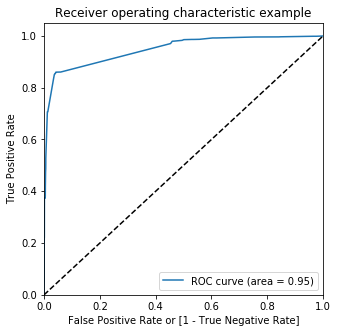

In [352]:
draw_roc(y_train_pred_final['Converted'], y_train_pred_final['Converted_Prob'])

### Finding Optimal Cutoff Point

In [353]:
# Columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]

for i in numbers:
    y_train_pred_final[i]= y_train_pred_final['Converted_Prob'].map(lambda x: 1 if x > i else 0)
    
y_train_pred_final.head()

,Converted,Converted_Prob,Prospect ID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.182597,3009,0,1,1,0,0,0,0,0,0,0,0
1,0,0.133249,1012,0,1,1,0,0,0,0,0,0,0,0
2,0,0.000773,9226,0,1,0,0,0,0,0,0,0,0,0
3,1,0.768495,4750,1,1,1,1,1,1,1,1,1,0,0
4,1,0.976792,7987,1,1,1,1,1,1,1,1,1,1,1


In [354]:
# Calculate accuracy, sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensitivity','specificity'])

num = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final['Converted'], y_train_pred_final[i])
    total1 = sum(sum(cm1))
    accuracy = (cm1[0, 0] + cm1[1, 1]) / total1
    
    speci = cm1[0, 0] / (cm1[0, 0] + cm1[0, 1])
    sensi = cm1[1, 1] / (cm1[1, 0] + cm1[1, 1])
    
    cutoff_df.loc[i] = [i , accuracy, sensi, speci]
    
print(cutoff_df)

     prob  accuracy  sensitivity  specificity
0.0   0.0  0.385136     1.000000     0.000000
0.1   0.1  0.689970     0.982829     0.506530
0.2   0.2  0.909621     0.860589     0.940333
0.3   0.3  0.918910     0.860180     0.955698
0.4   0.4  0.919698     0.858136     0.958259
0.5   0.5  0.919540     0.855683     0.959539
0.6   0.6  0.919855     0.854456     0.960819
0.7   0.7  0.920013     0.851186     0.963124
0.8   0.8  0.879232     0.708095     0.986428
0.9   0.9  0.813888     0.526574     0.993854


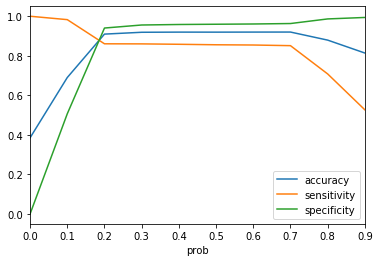

In [355]:
# Plot for accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy', 'sensitivity', 'specificity'])
plt.show()

From the curve above, around 0.2 is the optimum point to take it as a cutoff probability.

In [356]:
# Using the new cut-off value (0.2) from above
y_train_pred_final['predicted'] = y_train_pred_final['Converted_Prob'].map(lambda x: 1 if x > 0.2 else 0)
metrics.accuracy_score(y_train_pred_final['Converted'], y_train_pred_final['predicted'])

0.9096205321996536

### Assign Lead Score

In [357]:
y_train_pred_final['Lead Score'] = y_train_pred_final['Converted_Prob'].map(lambda x: round(x * 100))

y_train_pred_final.head()

,Converted,Converted_Prob,Prospect ID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,Lead Score
0,0,0.182597,3009,0,1,1,0,0,0,0,0,0,0,0,18
1,0,0.133249,1012,0,1,1,0,0,0,0,0,0,0,0,13
2,0,0.000773,9226,0,1,0,0,0,0,0,0,0,0,0,0
3,1,0.768495,4750,1,1,1,1,1,1,1,1,1,0,0,77
4,1,0.976792,7987,1,1,1,1,1,1,1,1,1,1,1,98


In [358]:
confusion = metrics.confusion_matrix(y_train_pred_final['Converted'], y_train_pred_final['predicted'])
confusion

array([[3672,  233],
       [ 341, 2105]])

In [359]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

# Let's see the sensitivity of our logistic regression model
sensitivity = TP / float(TP+FN)

# Let us calculate specificity
specificity = TN / float(TN+FP)

# Calculate false postive rate - predicting churn when customer does not have churned
fp_rate = FP/ float(TN+FP)

# Positive predictive value 
positive_pred_val = TP / float(TP+FP)

# Negative predictive value
negative_pred_val = TN / float(TN+ FN)

print(f'Sensitivity: {round(sensitivity, 3)}')
print(f'Specificity: {round(specificity, 3)}')
print(f'False-Positive rate: {round(fp_rate, 3)}')
print(f'Positive predictive value (precision): {round(positive_pred_val, 3)}')
print(f'Negative predictive value: {round(negative_pred_val, 3)}')

Sensitivity: 0.861
Specificity: 0.94
False-Positive rate: 0.06
Positive predictive value (precision): 0.9
Negative predictive value: 0.915


# Making Prediction on Test Set

In [360]:
# Scale only features which are not in between range 0 and 1
num_vars = ['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']

X_test[num_vars] = scaler.transform(X_test[num_vars])
X_train.head()

,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Source_Facebook,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,...,Last Notable Activity_Form Submitted on Website,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_Resubscribed to emails,Last Notable Activity_SMS Sent,Last Notable Activity_Unreachable,Last Notable Activity_Unsubscribed,Last Notable Activity_View in browser link Clicked
3009,-0.432779,-0.160255,-0.155018,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1012,-0.432779,-0.540048,-0.155018,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9226,-1.150329,-0.888650,-1.265540,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
4750,-0.432779,1.643304,-0.155018,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
7987,0.643547,2.017593,0.122613,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [361]:
X_test = X_test[col2]
X_test.head()

,Lead Origin_Lead Add Form,Lead Source_Welingak Website,Last Activity_Email Bounced,What is your current occupation_Working Professional,Tags_Busy,Tags_Closed by Horizzon,Tags_Lost to EINS,Tags_Ringing,Tags_Will revert after reading the email,Tags_switched off,Lead Quality_Not Sure,Lead Quality_Worst,Last Notable Activity_SMS Sent
3271,0,0,0,0,0,0,0,0,1,0,1,0,0
1490,0,0,0,1,0,0,0,0,1,0,0,0,0
7936,0,0,0,0,0,0,0,0,1,0,1,0,0
4216,1,0,0,0,0,1,0,0,0,0,0,0,0
3830,0,0,0,0,0,0,0,0,1,0,1,0,0


In [362]:
X_test_sm = sm.add_constant(X_test)
y_test_pred = res.predict(X_test_sm)
y_test_pred[:10]

3271    0.182597
1490    0.958995
7936    0.182597
4216    0.999026
3830    0.182597
1800    0.958995
6507    0.011362
4821    0.000400
4223    0.996331
4714    0.182597
dtype: float64

In [363]:
# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)
y_pred_1.head()

,0
3271,0.182597
1490,0.958995
7936,0.182597
4216,0.999026
3830,0.182597


In [364]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

# Putting Prospect ID to index
y_test_df['Prospect ID'] = y_test_df.index

# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)
y_pred_final.head()

,Converted,Prospect ID,0
0,0,3271,0.182597
1,1,1490,0.958995
2,0,7936,0.182597
3,1,4216,0.999026
4,0,3830,0.182597


In [365]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={0: 'Converted_Prob'})

# Rearranging the columns
y_pred_final = y_pred_final.reindex_axis(['Prospect ID', 'Converted', 'Converted_Prob'], axis=1)
y_pred_final.head()

,Prospect ID,Converted,Converted_Prob
0,3271,0,0.182597
1,1490,1,0.958995
2,7936,0,0.182597
3,4216,1,0.999026
4,3830,0,0.182597


In [366]:
# Use the cut-off as 0.2 from earlier
y_pred_final['final_predicted'] = y_pred_final['Converted_Prob'].map(lambda x: 1 if x > 0.2 else 0)
y_pred_final.head()

,Prospect ID,Converted,Converted_Prob,final_predicted
0,3271,0,0.182597,0
1,1490,1,0.958995,1
2,7936,0,0.182597,0
3,4216,1,0.999026,1
4,3830,0,0.182597,0


In [367]:
# Overall accuracy.
metrics.accuracy_score(y_pred_final['Converted'], y_pred_final['final_predicted'])

0.906720528828498